In [ ]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
PATH = "/content/drive/MyDrive/dataset/Covid19-dataset"

train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')
val_dir = os.path.join(PATH, 'valid')

In [ ]:
BATCH_SIZE = 32
INCEPTION_IMG_SIZE = (299,299)

inception_train_dataset = image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=INCEPTION_IMG_SIZE)
inception_valid_dataset = image_dataset_from_directory(val_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=INCEPTION_IMG_SIZE)
inception_test_dataset = image_dataset_from_directory(test_dir, batch_size=BATCH_SIZE, image_size=INCEPTION_IMG_SIZE)

Found 208 files belonging to 3 classes.
Found 49 files belonging to 3 classes.
Found 60 files belonging to 3 classes.


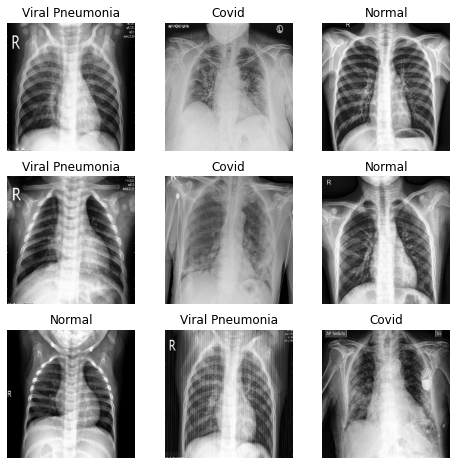

In [ ]:
class_names = inception_train_dataset.class_names

plt.figure(figsize=(8, 8))
for images, labels in inception_train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.03,),
  tf.keras.layers.GaussianNoise(0.3),
])

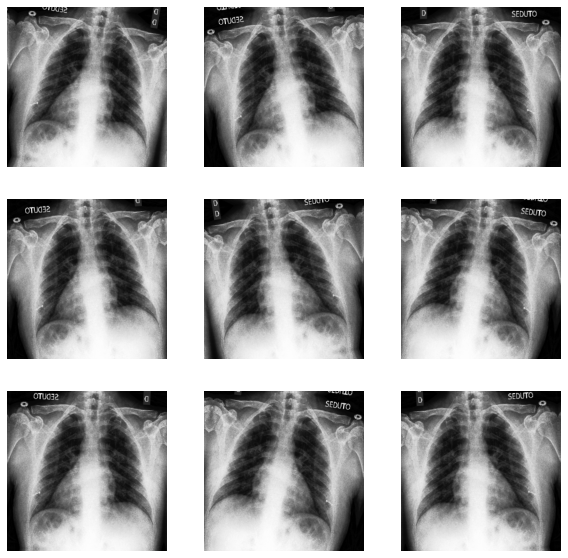

In [ ]:
for image, _ in inception_train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255)

In [ ]:
INCEPTION_IMG_SHAPE = INCEPTION_IMG_SIZE + (3,)
inception3v_base_model = tf.keras.applications.InceptionV3(input_shape=INCEPTION_IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(inception_train_dataset))
feature_batch = inception3v_base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 2048)


In [ ]:
inception3v_base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [ ]:
prediction_layer = tf.keras.layers.Dense(3, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [ ]:
inputs = tf.keras.Input(shape=INCEPTION_IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = inception3v_base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0   

In [ ]:
BASE_LEARNING_RATE = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LEARNING_RATE),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
INITIAL_EPOCHS = 50

history = model.fit(inception_train_dataset,
                    epochs=INITIAL_EPOCHS,
                    validation_data=inception_valid_dataset)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


7/7 [==============================] - 70s 9s/step - loss: 1.0789 - accuracy: 0.4808 - val_loss: 0.7996 - val_accuracy: 0.6939
Epoch 2/50
7/7 [==============================] - 59s 8s/step - loss: 0.6472 - accuracy: 0.7356 - val_loss: 0.6032 - val_accuracy: 0.8367
Epoch 3/50
7/7 [==============================] - 59s 8s/step - loss: 0.4959 - accuracy: 0.8221 - val_loss: 0.5096 - val_accuracy: 0.8163
Epoch 4/50
7/7 [==============================] - 60s 8s/step - loss: 0.3966 - accuracy: 0.8462 - val_loss: 0.4752 - val_accuracy: 0.8571
Epoch 5/50
7/7 [==============================] - 59s 8s/step - loss: 0.3499 - accuracy: 0.8846 - val_loss: 0.4438 - val_accuracy: 0.8163
Epoch 6/50
7/7 [==============================] - 61s 8s/step - loss: 0.3361 - accuracy: 0.8558 - val_loss: 0.4272 - val_accuracy: 0.8571
Epoch 7/50
7/7 [==============================] - 60s 8s/step - loss: 0.3012 - accuracy: 0.8846 - val_loss: 0.4114 - val_accuracy: 0.8571
Epoch 8/50
7/7 [=============================

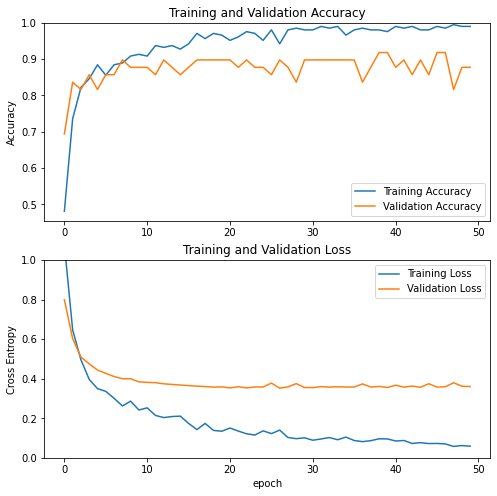

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()